In [158]:
# Importing Python libraries, majority of these won't be used but this is the standard mix of libraries I use
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import pdist, squareform
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression
import pymssql
import statsmodels.api as sm
from datetime import datetime
pd.set_option('display.max_rows', 100000)  
w=print
delimiter = '='*125

In [159]:
# Reading the datasets in CSV format
transaction = pd.read_csv(r"C:\\Users\JustinKo\Downloads\\bq-results-20200615-161534-41pi909jig9f.csv")
products = pd.read_csv(r"C:\\Users\JustinKo\Downloads\bq-results-20200615-164647-9re0migythvi.csv")
departments = pd.read_csv(r"C:\\Users\JustinKo\Downloads\bq-results-20200615-164826-z7ci3w93w6oi.csv")
dayofweek = pd.read_csv(r"C:\\Users\JustinKo\Downloads\bq-results-20200615-164906-1tid14sl6lu9.csv")
categories = pd.read_csv(r"C:\\Users\JustinKo\Downloads\bq-results-20200615-165005-abdcitukm8v4.csv")

In [160]:
# Print size,preview and data types of tables
# No issues with reading columns and their data types seem correct
for table in [transaction,products,departments,dayofweek,categories]:
    w(delimiter)
    w(table.shape)
    w(table.head())
    w(table.dtypes)
    w(delimiter)

(1652535, 8)
   customer_id  transaction_id  day_of_week_no  hour_of_day  product_id  \
0       139437         2271150               0            0       17487   
1       159865          684285               0            0       21386   
2       107387         2248377               0            7        7987   
3        47389         3130086               0            7       39812   
4        64868          421193               0            7       31915   

   quantity  price  sub_amount  
0        17   3.87       65.79  
1        19   9.76      185.44  
2        19   2.68       50.92  
3        17   2.88       48.96  
4        17   4.38       74.46  
customer_id         int64
transaction_id      int64
day_of_week_no      int64
hour_of_day         int64
product_id          int64
quantity            int64
price             float64
sub_amount        float64
dtype: object
(49688, 4)
   product_id                        product_name  category_id  department_id
0       21419              

In [161]:
# Question 1a, What is average transaction value per customer?
# Average transaction value per customer = total amount spent/number of unique customer
w('Average Transaction Value Per Customer $'+ str(transaction['sub_amount'].sum()/transaction['customer_id'].nunique()))

Average Transaction Value Per Customer $5423.6112219999995


In [162]:
# Question 1b, On which day of the week is the value the highest? 
# Logic: Join transaction and dayofweek and then groupby sum of dayofweekname
# By quantity, price and sub_amount, Saturday has the highest value. 
# No differences between 'right' or 'inner' join, but 'right' was used in case there were missing day names from 'dayofweek'
transaction_day = pd.merge(dayofweek, transaction, on = 'day_of_week_no', how = 'right')
transaction_day.groupby('day_of_week_name').sum().reset_index().sort_values('sub_amount', ascending = False)

,day_of_week_name,day_of_week_no,customer_id,transaction_id,hour_of_day,product_id,quantity,price,sub_amount
2,Sat,0,33488812878,555033480177,4381814,8346891501,1761814,1967916.55,10672942.69
3,Sun,285430,29241985318,486714290523,3773859,7306252940,1544491,1730858.07,9361261.54
0,Fri,1372836,23367679629,388367497677,3107104,5860565038,1244749,1381294.26,7505061.58
4,Thur,1067260,21705381194,369096000342,2839296,5470195650,1159068,1292064.93,7011499.43
1,Mon,425368,21593509010,365001329131,2841498,5434706781,1158402,1285641.33,6988925.09
6,Wed,778572,20085861993,331194483280,2662284,4968868624,1059948,1176828.71,6399497.72
5,Tue,578595,19731098231,329323360755,2623002,4928207067,1047410,1164319.84,6296924.17


In [163]:
# Question 2a, What are the top 10 most frequently purchased products in terms of transaction?
# Logic: Join transaction and products and then group by count selecting top 10
# Majority of top 10 items purchased are fresh fruits/veges, bananas are by far the most popular item 
transaction_prod = pd.merge(transaction, products, on = 'product_id', how = 'left')
transaction_prod.groupby('product_name').count().reset_index().sort_values('transaction_id', ascending = False).head(10)

,product_name,customer_id,transaction_id,day_of_week_no,hour_of_day,product_id,quantity,price,sub_amount,category_id,department_id
2571,Banana,24050,24050,24050,24050,24050,24050,24050,24050,24050,24050
2422,Bag of Organic Bananas,19466,19466,19466,19466,19466,19466,19466,19466,19466,19466
23040,Organic Strawberries,13077,13077,13077,13077,13077,13077,13077,13077,13077,13077
20493,Organic Baby Spinach,12309,12309,12309,12309,12309,12309,12309,12309,12309,12309
21688,Organic Hass Avocado,10865,10865,10865,10865,10865,10865,10865,10865,10865,10865
20463,Organic Avocado,9462,9462,9462,9462,9462,9462,9462,9462,9462,9462
15887,Large Lemon,7987,7987,7987,7987,7987,7987,7987,7987,7987,7987
16616,Limes,7469,7469,7469,7469,7469,7469,7469,7469,7469,7469
30877,Strawberries,7325,7325,7325,7325,7325,7325,7325,7325,7325,7325
23495,Organic Whole Milk,7142,7142,7142,7142,7142,7142,7142,7142,7142,7142


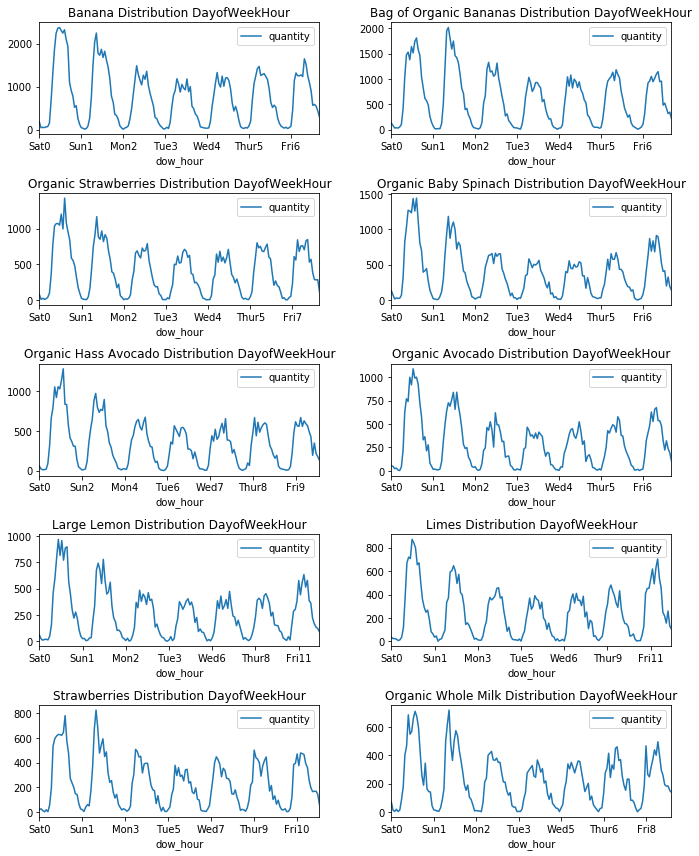

In [165]:
# Question 2b, How frequently are they purchased?
# I believe this is an open ended question with no direct answer, so I've plotted out the frequency of purchases over the
# week by hours. In SQL, I've given a more direct answer by taking the number of purchases divided by number of minutes in a week
# Even this approach is flawed as we're assuming this is the data for just one week and isn't a good representation of the
# item's sale
# To my knowledge, Aldi doesn't open 24 hours so it's surprising to see stores selling very early/late in the day

# Create a list of top 10 items sold
top_10_sold = ([i for i in (transaction_prod.groupby('product_name').sum().reset_index().sort_values(
    'quantity', ascending = False).head(10)['product_name'])])

# Join tables so I can plot DayofWeek and Hours whilst selecting top 10 
transaction_prod_dow = (pd.merge(dayofweek,pd.merge(transaction, products, on = 'product_id', how = 'left'), 
                                 on = 'day_of_week_no', how = 'right'))
transaction_prod_dow.groupby('product_name').count().reset_index().sort_values('quantity', ascending = False).head(10)

# Loop through departments and plot the frequency of each day
fig, ax = plt.subplots(5,2,figsize=(10,12))
ax = ax.ravel()
for num, product in enumerate(top_10_sold): 
    transaction_day_hour = (transaction_prod_dow[transaction_prod_dow['product_name']==product].groupby(
        ['day_of_week_name','hour_of_day','day_of_week_no']).sum().reset_index())
    transaction_day_hour.sort_values(by = ['day_of_week_no','hour_of_day'], inplace = True)
    transaction_day_hour['dow_hour'] = transaction_day_hour['day_of_week_name'] + transaction_day_hour['hour_of_day'].astype(str)
    transaction_day_hour.plot(x = 'dow_hour', y = 'quantity', ax=ax[num])
    ax[num].set_title(product + ' Distribution DayofWeekHour')
plt.tight_layout()

In [184]:
# Question 3, What are the top 10 categories with highest customer penetration
# Logic: join transaction, products, categories and then group by 'category'
# Then using the formula provided calculate customer penetration for each category
# Fresh fruits and veges have a significantly higher customer penetration rate doubling the third highest category 
# 'packaged vegetables fruits' in customer penetration
category_transaction = (pd.merge(categories, (pd.merge(transaction, products, on = 'product_id', how = 'inner')), 
                              on = 'category_id', how = 'inner'))
cat_cust_penetration = category_transaction.groupby('category').count().reset_index().iloc[:,:2]
cat_cust_penetration.columns = ['category','customer_count']
cat_cust_penetration['total_customer'] = cat_cust_penetration['customer_count'].sum()
cat_cust_penetration['customer_penetration'] = cat_cust_penetration['customer_count']*100/cat_cust_penetration['total_customer']
cat_cust_penetration.sort_values(by = 'customer_penetration', ascending = False).head(10)

,category,customer_count,total_customer,customer_penetration
50,fresh fruits,185961,1652535,11.253075
53,fresh vegetables,178819,1652535,10.820890
98,packaged vegetables fruits,91803,1652535,5.555283
133,yogurt,75778,1652535,4.585561
93,packaged cheese,50643,1652535,3.064564
83,milk,45490,1652535,2.752740
131,water seltzer sparkling water,40872,1652535,2.473291
25,chips pretzels,36730,1652535,2.222646
119,soy lactosefree,32153,1652535,1.945677
11,bread,29578,1652535,1.789856


In [204]:
# Question 4, Which coffee products does the company keep to make up to 90% of sales.
# Logic: Join categories, transaction, products and filter for only coffee category. Manipulate columns to produce
# proportion of sales for each product and cumulative sum proportion capping at 90%. I've filtered using 
# 90.033 to include the item which will bring it up past 90 as 89.99% is not up to 90%
# Interesting to see ~35% of items make up 90% of sales and we can delete 304 products from coffee category
category_transaction = (pd.merge(categories, (pd.merge(transaction, products, on = 'product_id', how = 'inner')), 
                              on = 'category_id', how = 'inner'))
coffee_sales = (category_transaction[category_transaction['category']=='coffee'].groupby('product_name').sum().
                reset_index()[['product_name','sub_amount']])
coffee_sales['total_coffee_sales'] = coffee_sales['sub_amount'].sum()
coffee_sales['proportion'] = coffee_sales['sub_amount']*100/coffee_sales['total_coffee_sales']
coffee_sales.sort_values('proportion',ascending = False, inplace = True)
coffee_sales['cumulative'] = coffee_sales['proportion'].cumsum()
coffee_sales[coffee_sales['cumulative']<=90.033]

,product_name,sub_amount,total_coffee_sales,proportion,cumulative
370,Original Cold Brew Coffee With Milk,9712.10,326310.7,2.976335,2.976335
338,New Orleans Iced Coffee,9694.94,326310.7,2.971076,5.947411
302,Major Dickason's Blend Ground Coffee Dark Roast,9146.18,326310.7,2.802905,8.750317
211,French Roast Whole Bean Coffee,8566.98,326310.7,2.625406,11.375723
20,Black Coffee,7947.27,326310.7,2.435492,13.811214
428,Tesora Medium Roast,7645.70,326310.7,2.343074,16.154288
313,Medium Roast Ground Coffee,7378.70,326310.7,2.261250,18.415538
181,Espresso Dark Roast Ground Coffee,7204.08,326310.7,2.207736,20.623274
104,Cold Brew Coffee,6679.68,326310.7,2.047031,22.670305
249,House Blend Deep Roast Ground Coffee,6150.60,326310.7,1.884891,24.555195


In [259]:
# Question 5, 30% discount on Tuesday for transactions with products from at least 3 different departments, what 
# would is the promotional value?
# Logic: Identify tractions that spread across 3 or more departments by joining transaction, products, day of week.
# Filter this result with only 'Tue' results and groupby transaction_id counting unique.
# Filter result to count of distinct department_id >=3. Take transaction_id and join with transactions to find total
# Value of these transactions. Finally, multiply the result by 0.3 to get the discount given through this promotion.
transaction_prod_dow = (pd.merge(dayofweek,pd.merge(transaction, products, on = 'product_id', how = 'inner'),
                                 on = 'day_of_week_no', how = 'right'))
tues_transaction = (transaction_prod_dow[transaction_prod_dow['day_of_week_name']=='Tue'])
trans_depts = pd.DataFrame(tues_transaction.groupby(['transaction_id']).nunique()['department_id']).reset_index()
trans_depts.columns = ['transaction_id','distinct_department_id']
trans_depts_full = pd.merge(trans_depts[trans_depts['distinct_department_id']>=3], transaction, on = 'transaction_id', how = 'inner')
w('30% discount promotion would have costed the company $'+ str(trans_depts_full['sub_amount'].sum()*0.3))

30% discount promotion would have costed the company $1734961.1369999999
